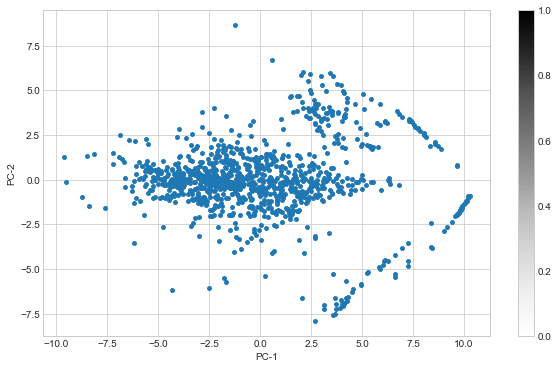

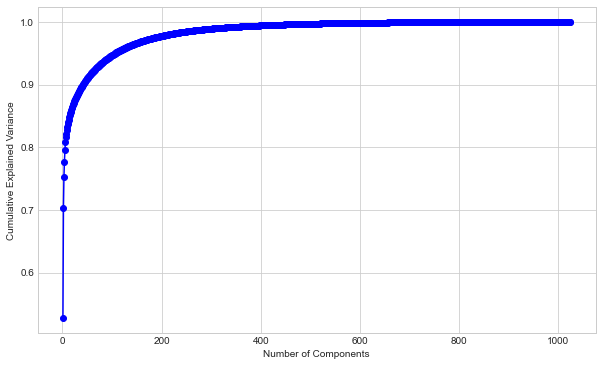

PCA transformed data saved to disk with shape:  (1100, 106)
Do you want to use the dataset before PCA (y) or after PCA (n) ? (y/n)
y
scores: 
    Accuracy  Recall  Precision  F1-score  Support
0      0.96     0.5       0.75       0.6     0.96
  False negatives False positives True negatives True positives
0               3               1             93              3


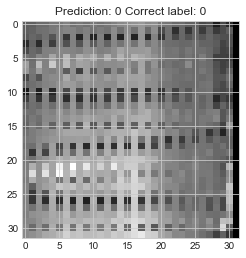

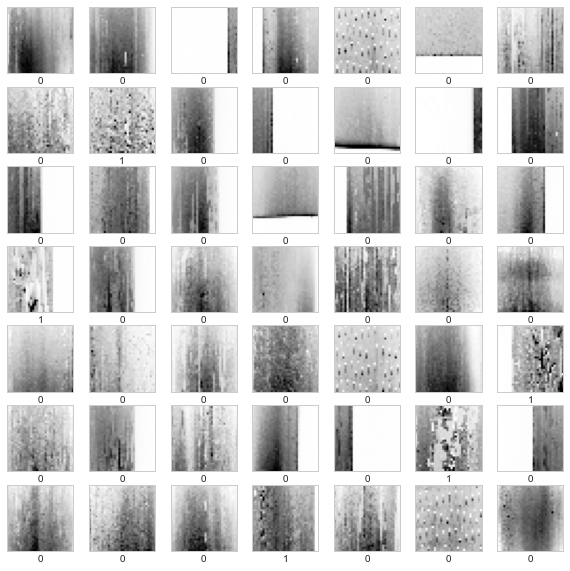

Training the model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None

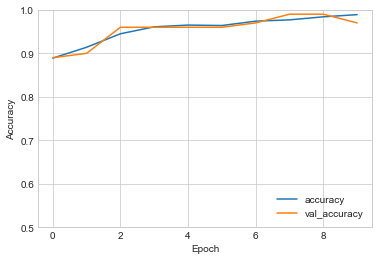

4/4 - 0s - loss: 0.0918 - MSE: 0.0250 - accuracy: 0.9700 - precision: 1.0000 - recall: 0.7273
   test_loss  test_acc   MSE  precision    recall
0   0.091756  0.024996  0.97        1.0  0.727273
Model saved to disk


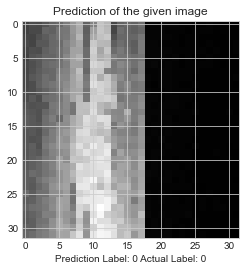

In [5]:
from cgi import test
from hashlib import new
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from sklearn.decomposition import PCA
import sklearn
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


# charge les images dynamiquement à partir du path défini dans chemin.txt
# et les retourne sous forme de dictionnaire avec le path et la valeur de la classe
# (0 ou 1)
def load_images_from_path():
    all_images = []
    with_default_arr = []
    without_default_arr = []

    folders = ["with_default", "without_default"]
    chemin = os.path.join(os.path.dirname("__file__"), './Data/chemin.txt')

    with open(chemin, 'r') as f:
        chemin_images = f.read()

    for folder in folders:
        for file in os.listdir(os.path.join(chemin_images, folder)):
            if file.endswith(".jpg"):
                all_images.append({"path": os.path.join(
                    chemin_images, folder, file), "label_value": 1 if folder == "with_default" else 0})
                if folder == "with_default":
                    with_default_arr.append(os.path.join(
                        chemin_images, folder, file))
                else:
                    without_default_arr.append(os.path.join(
                        chemin_images, folder, file))

    # randomize the order of the images
    random.shuffle(all_images)
    # split the dataset into training and testing datasets
    # with 90% of the data in the training dataset and 10% in the testing dataset
    train_dataset = np.array(all_images[:1000])
    test_dataset = np.array(all_images[-100:])

    train_labels = np.array([x["label_value"] for x in train_dataset])
    test_labels = np.array([x["label_value"] for x in test_dataset])

    # load the images from the paths
    train_images_loaded = np.array([cv2.imread(train_path, 0) for train_path in np.array(
        [image["path"] for image in train_dataset])])
    test_images_loaded = np.array([cv2.imread(test_path, 0) for test_path in np.array(
        [image["path"] for image in test_dataset])])

    # resize images to 32x32
    train_images_loaded = np.array([cv2.resize(img, (32, 32)).flatten()
                                    for img in train_images_loaded])
    test_images_loaded = np.array([cv2.resize(img, (32, 32)).flatten()
                                   for img in test_images_loaded])

    return all_images, test_images_loaded, train_images_loaded, test_labels, train_labels, train_dataset, test_dataset


def random_forest():
    # ask user if he wants to use the default dataset or not
    # if yes, load the default dataset
    # if no, load the dataset without default
    print("Do you want to use the dataset before PCA (y) or after PCA (n) ? (y/n)")
    default = input()
    if default == "y":
        all_images, test_images_loaded, train_images_loaded, test_labels, train_labels, train_dataset, test_dataset = load_images_from_path()
    else:
        # load dataset from npy file
        # if the dataset file doesnt exist, skip this step
        all_images, test_images_loaded, train_images_loaded, test_labels, train_labels, train_dataset, test_dataset = load_images_from_path()
        try:
            all_images_loaded = np.load("pca_transformed_data.npy")

            print("taille all_images_loaded: ", len(all_images_loaded))
            train_images_loaded = np.array(all_images_loaded[:1000])
            test_images_loaded = np.array(all_images_loaded[-100:])
        except Exception:
            print("The dataset file doesnt exist, loading the dataset without PCA")

    # Create a RandomForestClassifier with 100 trees
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=100)

    # fit the random forest classifier on the training dataset
    rf.fit(train_images_loaded, train_labels)

    # predict the labels of the test dataset
    predictions = rf.predict(test_images_loaded)

    # summarize all these scores in dataframe
    scores = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision',
                                   'F1-score', 'Support'])

    # calculate some metrics about the model
    scores.loc[0] = [sklearn.metrics.accuracy_score(
        test_labels, predictions), sklearn.metrics.recall_score(
        test_labels, predictions), sklearn.metrics.precision_score(
        test_labels, predictions), sklearn.metrics.f1_score(
        test_labels, predictions), sklearn.metrics.accuracy_score(
        test_labels, predictions)]

    false_negatives_count = sum(
        predictions[i] == 0 and test_labels[i] == 1 for i in range(len(test_images_loaded)))

    false_positives_count = sum(
        predictions[i] == 1 and test_labels[i] == 0 for i in range(len(test_images_loaded)))

    true_negatives_count = sum(  # true negatives
        predictions[i] == 0 and test_labels[i] == 0 for i in range(len(test_images_loaded)))

    true_positives_count = sum(  # true positives
        predictions[i] == 1 and test_labels[i] == 1 for i in range(len(test_images_loaded)))

    # create dataframe with the metrics
    # print the dataframe
    metrics = pd.DataFrame(columns=['False negatives', 'False positives',
                                    'True negatives', 'True positives'])
    metrics.loc[0] = [false_negatives_count, false_positives_count,
                      true_negatives_count, true_positives_count]
    print("scores: \n", scores)
    print(metrics)

    # comme le modèle sans ACP est le plus performant
    # on autorise la prédiction d'une image que si l'ACP
    # n'est pas faite
    if default == "y":
        # resize the image
        image_to_test = test_images_loaded[0]
        image_to_test = image_to_test[5]
        image = cv2.resize(test_images_loaded[0], (32, 32))
        # flatten the image
        image = image.flatten()
        # predict the label of the image
        prediction = rf.predict(np.array([image]))
        # plot the image, the predictions of the image and the correct label
        plt.imshow(test_images_loaded[0].reshape(32, 32), cmap='gray')
        plt.title("Prediction: " +
                  str(prediction[0]) + " Correct label: " + str(test_labels[0]))
        plt.show()


# create a convolutional neural network with 4 convolution layers, 1 pooling layer and 1 fully connected layer
# to classify images and identify when a metal is defective or not
def create_model():
    all_images, test_images_loaded, train_images_loaded, test_labels, train_labels, train_dataset, test_dataset = load_images_from_path()

    # Reshape & Normalize the images to be between 0 and 1
    test_images_loaded = test_images_loaded.reshape(
        100, 32, 32, 1) / 255
    train_images_loaded = train_images_loaded.reshape(
        1000, 32, 32, 1) / 255

    # show images and labels
    plt.figure(figsize=(10, 10))
    for i in range(49):
        plt.subplot(7, 7, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_images_loaded[i])
        plt.xlabel(train_dataset[i]["label_value"])
    plt.show()

    # if the model exists, make a prediction on the test dataset
    # otherwise, create, train the model, save it, and make a prediction on the test dataset
    if os.path.exists("metal_prediction.h5"):
        predict(test_images_loaded[0], test_labels[0])

    else:
        # create a convolution neural network to predict the class of the images (metal or not metal)
        # of size 32x32 with 4 convolution layers, 1 pooling layer and 1 fully connected layer
        # then print the model summary

        model = models.Sequential()
        model.add(layers.Conv2D(32, kernel_size=(3, 3),
                                activation='relu', input_shape=(32, 32, 1)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        model.add(layers.Dropout(0.25))
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                      optimizer='adam', metrics=['MSE', 'accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

        print("Training the model...")

        model.summary()

        # train the model
        history = model.fit(train_images_loaded, train_labels, epochs=10,
                            validation_data=(test_images_loaded, test_labels))

        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.5, 1])
        plt.legend(loc='lower right')
        plt.show()

        # Try the model on the test dataset
        test_loss, test_acc, MSE, precision, recall = model.evaluate(
            test_images_loaded,  test_labels, verbose=2)

        # print df of test_acc, test_loss, val_acc, val_loss and MSE
        df = pd.DataFrame(
            columns=['test_loss', 'test_acc', 'MSE', "precision", ' recall'])
        df.loc[0] = [test_loss, test_acc, MSE, precision, recall]

        print(df)

        # save the model trained to disk for later use
        model.save('metal_prediction.h5')
        print("Model saved to disk")

        # predict the label of the given image
        predict(test_images_loaded[0], test_labels[0])


# make a principal component analysis on the images
# to keep only the important features of the images
# and plot the results of the analysis to see which features are important
def pca_analysis_with_plot():
    all_images, *_ = load_images_from_path()

    # load and normalize the images to be between 0 and 1
    all_images_loaded = np.array([cv2.imread(img, 0) for img in np.array(
        [image["path"] for image in all_images])]) / 255

    # remove last dimension
    # all_images_loaded = all_images_loaded[:, :, :, 0]

    all_images_loaded = np.array([cv2.resize(img, (32, 32)).flatten()
                                  for img in all_images_loaded])

    pca = PCA()
    converted_data = pca.fit_transform(all_images_loaded)

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(10, 6))
    c_map = plt.cm.get_cmap('jet', 10)
    plt.scatter(converted_data[:, 0], converted_data[:, 1], s=15,
                cmap=c_map)
    plt.colorbar()
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    plt.show()

    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

    # plot percentage of variance explained
    plt.figure(figsize=(10, 6))
    # plot number of components vs. cumulative variance
    plt.plot(range(1, len(exp_var_cumul) + 1), exp_var_cumul, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    pca = PCA(svd_solver='full', n_components=0.95)
    pca.fit_transform(all_images_loaded)
    all_images_loaded = pca.transform(all_images_loaded)
    # save the transformed data after pca

    np.save("pca_transformed_data.npy", all_images_loaded)

    print("PCA transformed data saved to disk with shape: ",
          all_images_loaded.shape)


def predict(image, label):
    model = tf.keras.models.load_model("metal_prediction.h5")
    prediction = model.predict(image.reshape(1, 32, 32, 1))

    plt.imshow(image.reshape(32, 32), cmap='gray')
    plt.title("Prediction of the given image")
    plt.xlabel("Prediction Label: " +
               str(np.argmax(prediction))
               + " Actual Label: " + str(label))
    plt.show()


def main():
    pca_analysis_with_plot()
    random_forest()
    create_model()


main()